In [82]:
import os 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [83]:
def agg_time(df):
    times = []
    for index, row in df.iterrows():
        times.append(f"{str(row['year']).split('.')[0]}-{str(row['month']).split('.')[0]}-{str(row['day']).split('.')[0]} {str(row['hour']).split('.')[0]}:{str(row['minute']).split('.')[0]}:00")

    df['time (PST)'] = pd.to_datetime(times)
    df = df.sort_values(by='time (PST)', ascending=True)
    df.drop(['year', 'month', 'day', 'hour', 'minute'], axis=1, inplace=True)

    return df

def subset_summer(df):
    df.set_index('time (PST)', inplace=True)
    df = df[df.index.month.isin([5,6,7,8,9])]
    df.reset_index(inplace=True)

    return df

## Data QC 

In [84]:
#### Specify Arguments ###
# Source data paths
src_dir = '/Users/patmccornack/Documents/ucsb_fog_project/SCI_Fog_Project_Repo/data/01_raw/met_station/still-lab/'
src_fname = 'sauc-2003-2008.csv'
src_fpath = os.path.join(src_dir, src_fname)

# Out paths
outdir = '/Users/patmccornack/Documents/ucsb_fog_project/SCI_Fog_Project_Repo/data/02_clean/'
out_fname = 'sauc-summer-clean-2003-2008.csv'
out_fpath = os.path.join(outdir, out_fname)

# Define variables
var_dict = {
    'year' : 'Year',
    'month' : 'Month',
    'day' : 'Day',
    'hour' : 'Hour',
    'minute' : 'Minute',
    'fog' :'Fog',
    'air temperature (C)' : 'Temp',
    'relative humidity (%)' : 'RH',
    'wind speed (m/s)' : 'WS_MS_S_WVT',  # Has same values as 'WindSpd', but no missing observations
    'wind gust (m/s)' : 'WS_MS_MAX',
    'wind direction (deg)' : 'WindDir',
    'rain (mm)' : 'Rain',  # Unsure about units
    # 'solar radiation (kwm2)' :'Pyran_Avg',  # Data is suspect - 0s during day, nonzeros at night - plus missing many values
    # 'leaf wetness (mv)' : 'LeafWet'  # Missing many values, leaving out. Unsure if values coded as 99999 are NA
}

# Fog tip value
fog_tip_v = 4.714

# Options
process_time = True
summer_subset = True

In [85]:
#### Read in and prepare data ####
df = pd.read_csv(src_fpath)
df = df[list(var_dict.values())]
df.columns = list(var_dict.keys())

# Create fog tip var
df['fog tips'] = df['fog'] / fog_tip_v

# Create single datetime column
if process_time == True:
    df = agg_time(df)
    
# Subset to summer months
if summer_subset == True:
    df = subset_summer(df)

df.head(3)

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),fog tips
0,2004-05-01 00:00:00,0.0,15.45,51.74,2.60,3.33,327.70,0.0,0.0
1,2004-05-01 00:15:00,0.0,15.74,49.51,2.08,2.33,326.27,0.0,0.0
2,2004-05-01 00:30:00,0.0,15.42,52.07,1.79,2.15,321.58,0.0,0.0


### Missing Values
Observations:
1. Wind speed and leaf wetness in the original dataset are missing over half of their values.
2. ~~Solar radiation is missing around a quarter of observations. ~~
3. There are missing timestamps, which are likely completely empty observations. 
4. There's a very small number of missing observations for other variables. 

Actions:
1. Drop missing observations


In [86]:
df = df.dropna(subset=['time (PST)'])

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87850 entries, 0 to 87849
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time (PST)             87850 non-null  datetime64[ns]
 1   fog                    87850 non-null  float64       
 2   air temperature (C)    87849 non-null  float64       
 3   relative humidity (%)  87849 non-null  float64       
 4   wind speed (m/s)       87850 non-null  float64       
 5   wind gust (m/s)        87849 non-null  float64       
 6   wind direction (deg)   87850 non-null  float64       
 7   rain (mm)              87850 non-null  float64       
 8   fog tips               87850 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 6.0 MB


In [88]:
# When are values missing? 
missing = df.loc[df.isna().any(axis=1)]
pd.to_datetime(missing['time (PST)']).describe()

count                      1
mean     2007-07-14 12:45:00
min      2007-07-14 12:45:00
25%      2007-07-14 12:45:00
50%      2007-07-14 12:45:00
75%      2007-07-14 12:45:00
max      2007-07-14 12:45:00
Name: time (PST), dtype: object

In [89]:
# Drop Missing
df = df.dropna()

### Univariate Distributions

Check boxplots of each variable to assess data quality.

Observations:
1. Relative humidity is typically high at the site. 
2. Wind typically comes from the northwest, but has a higher spread than pozo.  
3. Most fog observations are 0 - this skews the distribution.
4. There are RH values above 100. 
5. ~~It looks like the pyranometer values are probably in w/m2~~ Not currently using pyranometer. 

Actions
1. Set observations where RH is above 100 to 100. 
2. Check the observations where RH is 0. 
3. Look closer at the distribution of the fog values.
4. ~~Correct solar radiation to represent kw/m2.~~ Not currently using pyranometer values. 

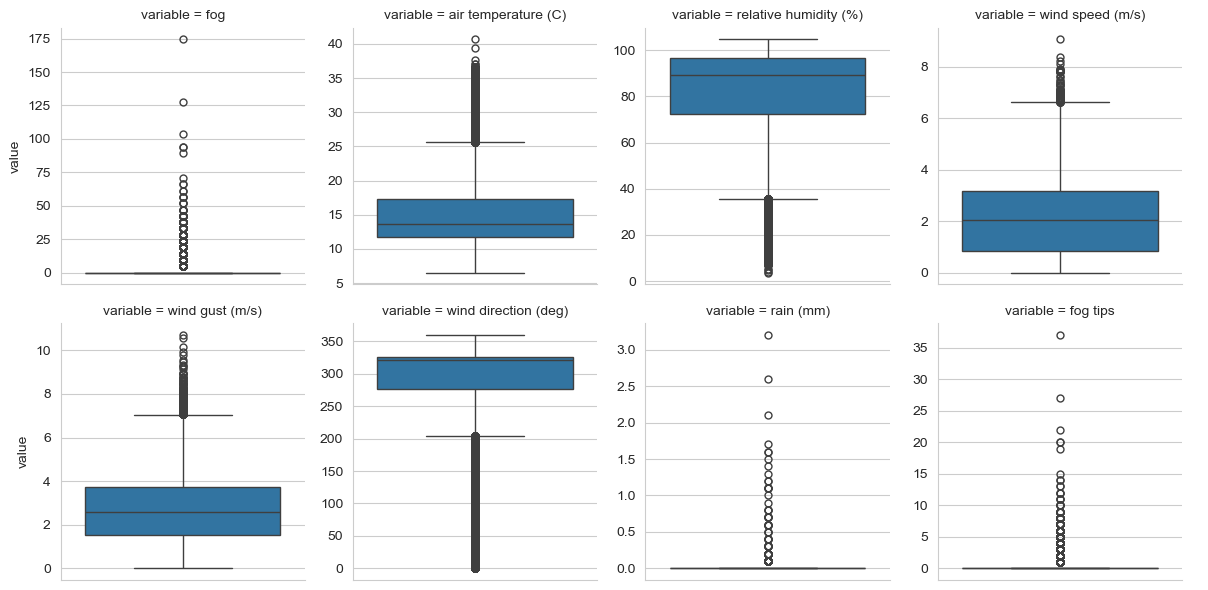

In [90]:
#### Quick plot of distributions ####
# Create long form data
value_col = df.columns.drop(['time (PST)']).tolist()
df_long = pd.melt(df, id_vars=['time (PST)'], value_vars=value_col)

# Plot boxplots
sns.catplot(data=df_long, kind='box', col='variable', y='value',
            sharey=False, height=3, col_wrap=4)
plt.show()


In [91]:
#### Check the actual values ####
df.describe()

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),fog tips
count,87849,87849.000000,87849.000000,87849.000000,87849.000000,87849.000000,87849.000000,87849.000000,87849.000000
mean,2007-01-14 18:14:59.907796480,0.642904,14.978022,81.867682,2.090345,2.646355,269.085467,0.000732,0.136382
min,2004-05-01 00:00:00,0.000000,6.540000,3.704000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005-07-15 18:30:00,0.000000,11.790000,72.200000,0.849000,1.550000,277.200000,0.000000,0.000000
50%,2006-09-29 13:00:00,0.000000,13.700000,89.100000,2.062000,2.587000,321.300000,0.000000,0.000000
75%,2008-07-17 05:15:00,0.000000,17.340000,96.500000,3.160000,3.750000,325.900000,0.000000,0.000000
max,2009-09-30 23:45:00,174.420000,40.670000,104.700000,9.070000,10.700000,359.500000,3.200000,37.000424
std,NaN,2.933320,4.593746,19.124391,1.453493,1.556977,101.021629,0.025325,0.622257


### Set RH > 100 to 100

In [92]:
df['relative humidity (%)'] = df['relative humidity (%)'].apply(lambda x: 100 if x > 100 else x)

### ~~Scale solar radiation~~
~~Solar radiation is measured in w/m2 based on the data, scale it to be kw/m2.~~

In [93]:
#df['solar radiation (kwm2)'] = df['solar radiation (kwm2)'] / 1000

### Fog Check
Given the focus of further analysis on fog at the site, further check the distribution of fog.

Observations:
1. Nothing of note, the distribution is as expected. 


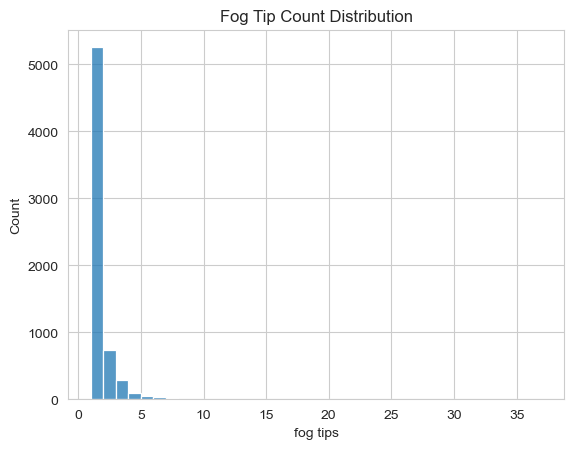

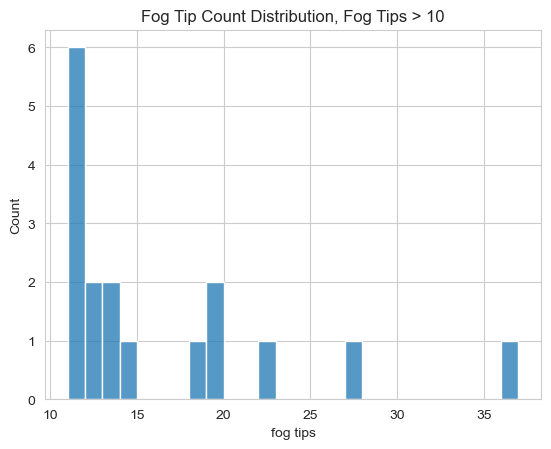

In [94]:
#### Check Distribution of Fog Values ####
sns.histplot(df['fog tips'].loc[df['fog tips']>0],
             binwidth=1)
plt.title('Fog Tip Count Distribution')
plt.show()

# Check right tail of distribution
sns.histplot(df['fog tips'].loc[df['fog tips']>10],
             binwidth=1)
plt.title('Fog Tip Count Distribution, Fog Tips > 10')
plt.show()

### Save out cleaned data

In [95]:
#### Save out cleaned data ####
df.to_csv(out_fpath)
print(out_fpath)

/Users/patmccornack/Documents/ucsb_fog_project/SCI_Fog_Project_Repo/data/02_clean/sauc-summer-clean-2003-2008.csv
